**CDKM Ripple Carry Adder - DELAY EFFECT:**


1. Import libraries & Define backend:

In [26]:
# Import libraries
import quantumaudio
from quantumaudio.tools import test_signal, plot
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import CDKMRippleCarryAdder
from qiskit_aer import AerSimulator
import numpy as np

# Define backend
backend = AerSimulator(method='statevector')


2. Define functions to be used throughout the notebook:

In [27]:
# Function that applies x gates to the time qubits to introduce a delay depending on the number of steps chosen by the user
def compute_delay_steps(steps, time_qubits, num_samples, time_delta, encoded_circuit):
    if steps > num_samples/2:
        raise ValueError("Number of steps too big")
    else:
        # Convert variable steps to binary
        steps_bin = format(steps, 'b')
        #print(steps_bin)
        # Add zeros before the binary number if the number of bits is less than the number of qubits
        steps_bin = '0'*(time_qubits-len(steps_bin)) + steps_bin
        #print(steps_bin)
        # Add an x gate on every bit that is 1
        for i, bit in enumerate(steps_bin):
            #print(i, bit)
            if bit == '1':
                encoded_circuit.x(time_delta[time_qubits-i-1])
                #print(time_delta[time_qubits-i-1])

3. Generate signal and encode it:

In [28]:
# Define amplitude and time registers
time_qubits = 4  # number of qubits used to represent the time
amp_qubits = 4  # number of qubits used to represent the amplitude
time_reg = QuantumRegister(time_qubits, 'time')  # time register
amp_reg = QuantumRegister(amp_qubits, 'amp')  # amplitude register

# Compute number of samples based on the number of qubits used to represent the time
num_samples = 2**time_qubits

# Import test signal
signal = test_signal(num_channels=1, num_samples=num_samples)
signal = np.array([0.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
scheme = quantumaudio.load_scheme('qsm', qubit_depth=amp_qubits)  # load the QSM scheme
encoding = scheme.encode(signal, verbose=0, measure=False)

# Create the encoded circuit
encoded_circuit = QuantumCircuit()
encoded_circuit.add_register(amp_reg)
encoded_circuit.add_register(time_reg)
encoded_circuit.compose(encoding, inplace=True)
# print("\nEncoded Circuit:")
# encoded_circuit.draw(output='mpl')

Quantum State Modulation


4. Delay effect:

Ancillae qubits: 10
Total qubits: 18

Encoded Circuit with Delay & Measurements:


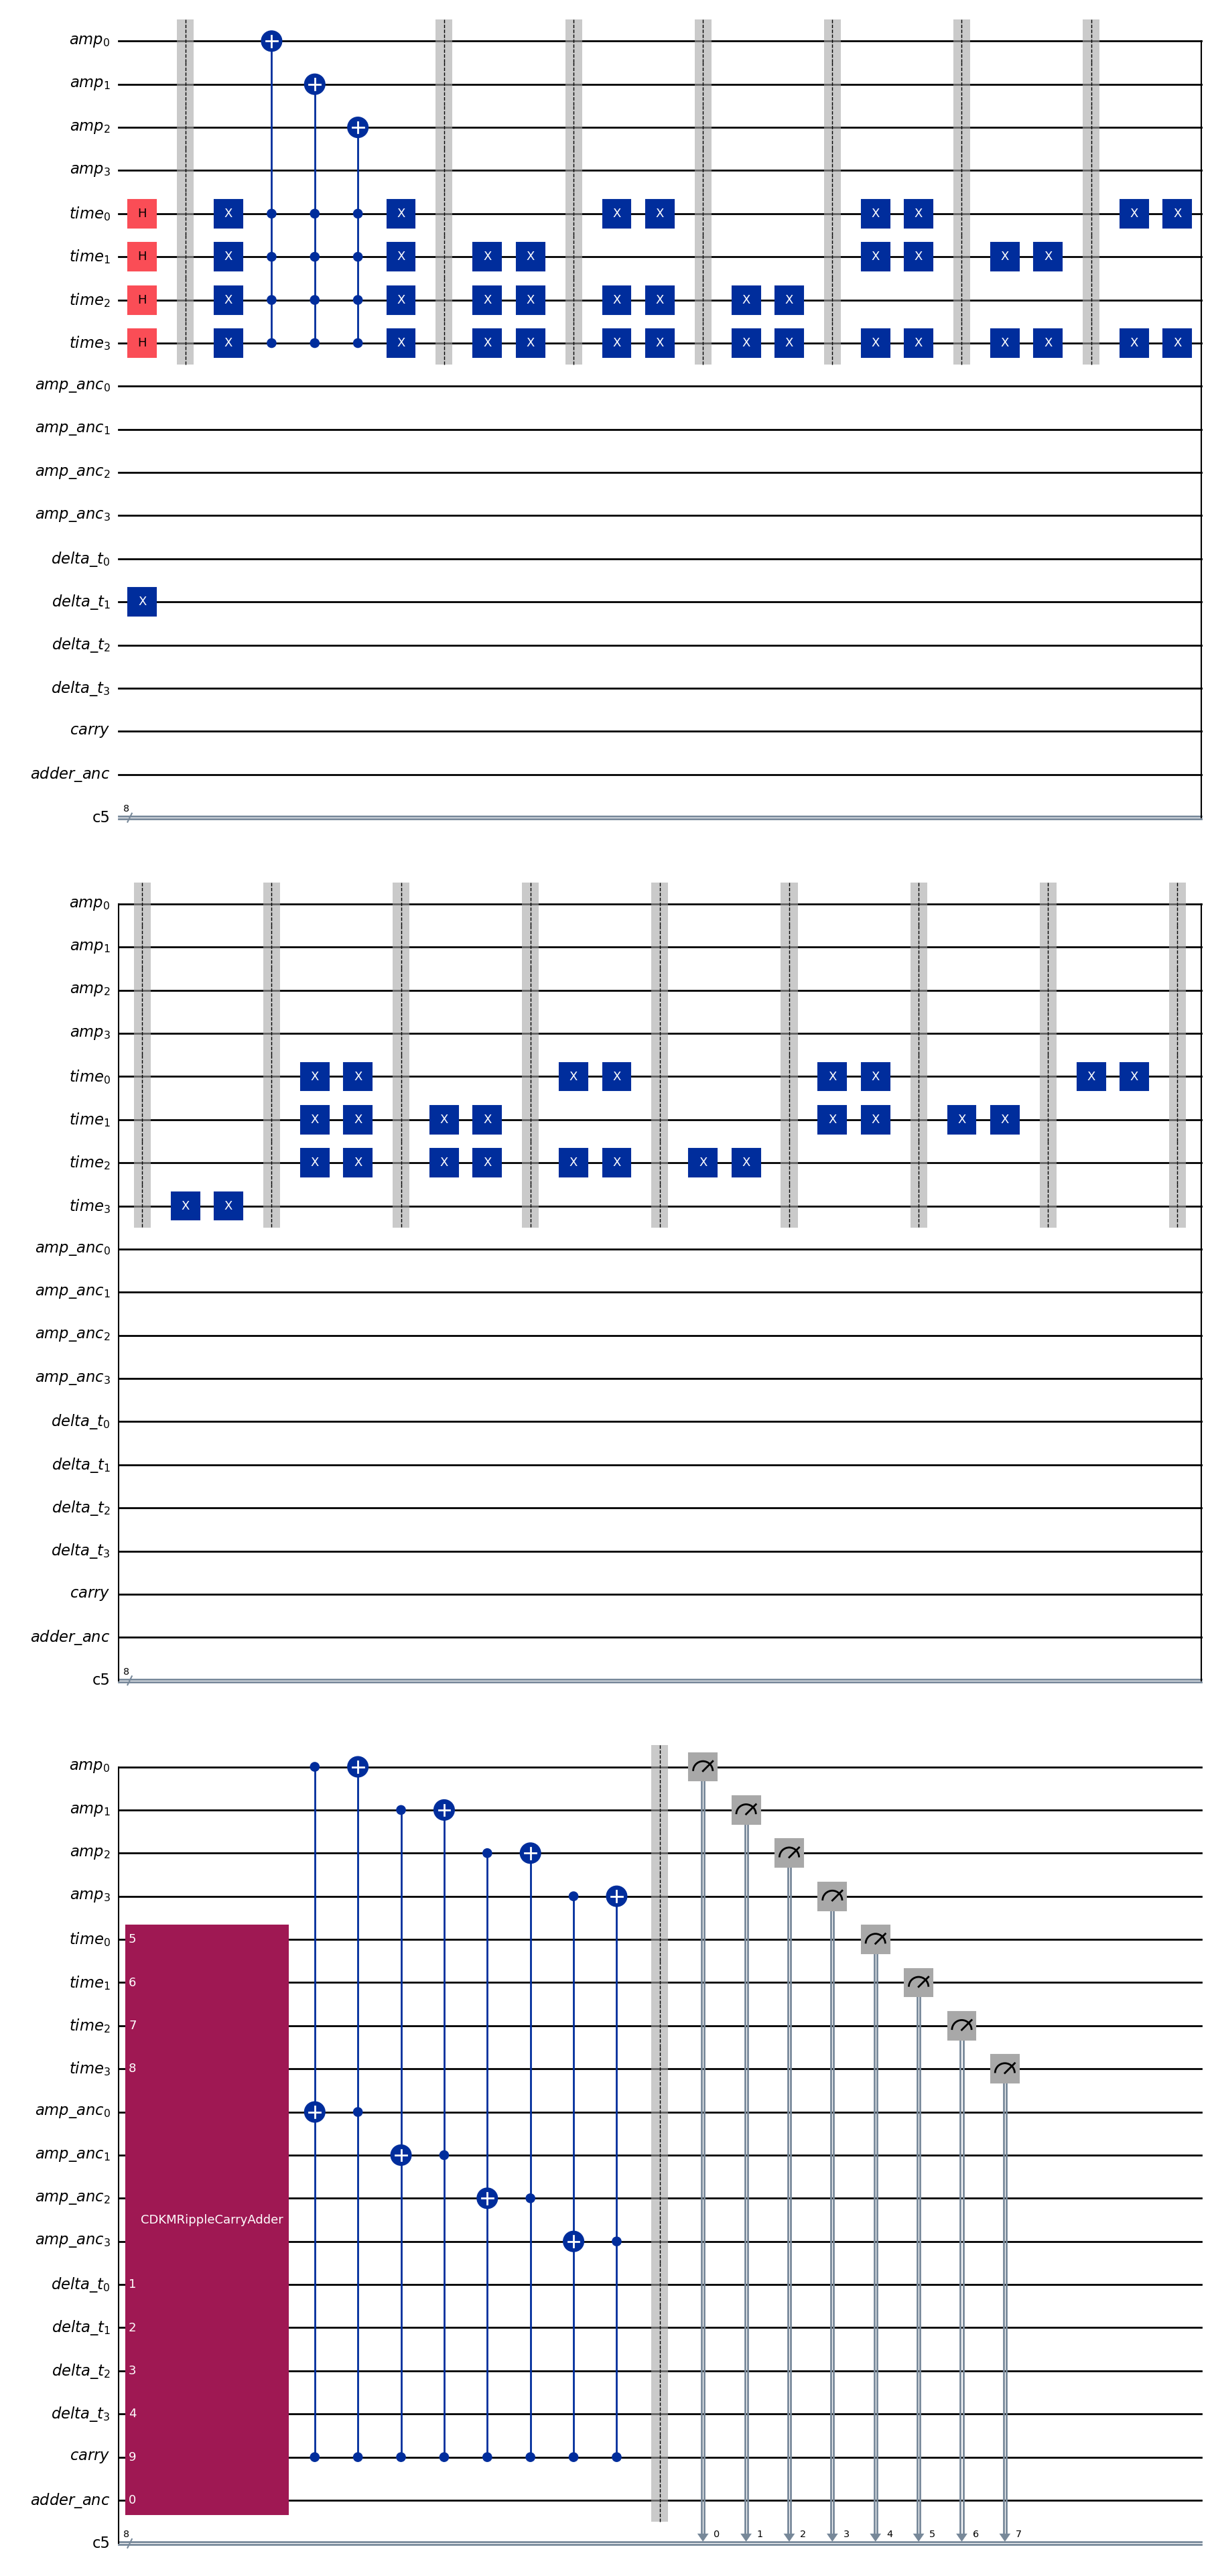

In [ ]:
# --- ADD ANCILLAE QUBITS ---
# Compute the number of ancillae qubits needed
ancillae_qubits = amp_qubits + time_qubits + 2 # amplitude ancilla + time intervals + carry + adder ancilla
print("Ancillae qubits:", ancillae_qubits)

# Compute the total number of qubits
total_qubits = time_qubits + amp_qubits + ancillae_qubits # total number of qubits
print("Total qubits:", total_qubits)

# Define the ancillae registers
amp_anc = QuantumRegister(amp_qubits, name='amp_anc') 
time_delta = QuantumRegister(time_qubits, name='delta_t')
carry = QuantumRegister(1, name='carry')
add_anc = QuantumRegister(1, name='adder_anc')

# Add ancillae qubits to the circuit
encoded_circuit.add_register(amp_anc) # add amplitude ancillae
encoded_circuit.add_register(time_delta) # add time intervals
encoded_circuit.add_register(carry) # carry qubit
encoded_circuit.add_register(add_anc) # add adder ancilla

# --- DELAY: TIME ADDER CIRCUIT ---
# Compute the number of steps to delay the signal
steps = 2
compute_delay_steps(steps, time_qubits, num_samples, time_delta, encoded_circuit)

# TIME CDKM RIPPLE CARRY ADDER CIRCUIT
# Initialize the CDK Ripple Carry Adder circuit
cdk_adder = CDKMRippleCarryAdder(time_qubits, kind = 'full')

# Append the adder to the circuit
encoded_circuit.append(cdk_adder, add_anc[:]+time_delta[:]+time_reg[:]+carry[:])

# --- DELAY: SETTING AMPLITUDES THAT GO TO ZERO ---
# Define the target pairs for the ccx gates
target_pairs = []
for i in range(amp_qubits):
    target_pairs.append((amp_reg[i], amp_anc[i]))
    target_pairs.append((amp_anc[i], amp_reg[i]))
    
# Apply the ccx operations in a loop
for ctrl2, target in target_pairs:
    encoded_circuit.ccx(carry, ctrl2, target)
encoded_circuit.barrier()

# --- MEASUREMENTS ---
num_measurements = time_qubits + amp_qubits  # we want to measure the first amp and time qubits
if encoded_circuit.num_clbits < num_measurements:
    encoded_circuit.add_register(ClassicalRegister(num_measurements - encoded_circuit.num_clbits))
# Measure only the first n+m qubits
encoded_circuit.measure(range(num_measurements), range(num_measurements)) # ([quantum register], [classical register])

print("\nEncoded Circuit with Delay & Measurements:")
encoded_circuit.draw(output='mpl')

5. Decoded signal and plot comparison:


Original Signal:
[0.9 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]

Decoded Signal:
[0.    0.    0.875 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]

Plot:


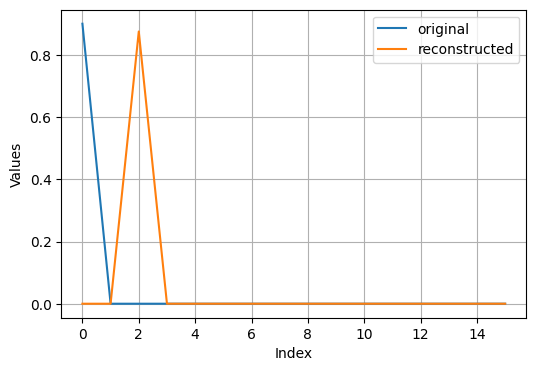

In [30]:
decoded_signal = scheme.decode(encoded_circuit, metadata={'qubit_shape':(time_qubits, amp_qubits),'num_samples':2**time_qubits}, backend=backend)

print("\nOriginal Signal:") 
print(signal)
print("\nDecoded Signal:")
print(decoded_signal)
print("\nPlot:")
plot([signal, decoded_signal])